This notebook will use noaa sst product to create a yearly SST index for a point in each hadley cell region.  

Procedure: 
    1. Read in SST data and load hadley indices 
    2. Sort data into DJF and combine months to yearly DJF means
    3. Align array to start in 1948
    4. Import HC index 
    5. Plot both 
    
 ***Additional functionality was made to plot the same data with monthly time intervals 

In [10]:
#################################################################
#############   Import all necessary packages    ################
#################################################################

import importlib
import plotly
import netCDF4 as nc
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import plotly.plotly as py 
import plotly.tools as tls
from plotly.graph_objs import * 

import numpy as np 
from scipy.io import netcdf 
from mpl_toolkits.basemap import Basemap

#reference points for defining various cells 
s_atlantic_ref = [-22.5,14.4]
s_pacific_ref  = [-17.5,-75.5]
s_indian_ref   = [-26.14, 113.15]

filename = r'C:\Users\Nathaniel\Desktop\Summer2018\HC_Summer2018\Data\noaa.ext.reconstr.v5.01.1854-04.2018.nc'

plotly.tools.set_credentials_file(username='ncresswell', api_key='XVFWb00wZKWyDJTrB2Dl')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def read_nc_file( filename ):
    
    print('Reading netCDF file...')
    
    #extract lon, lat, level and data stored in the netCDF file specified 
    with nc.Dataset(filename,'r') as f:
        lon   = f.variables['lon'][::]
        lat   = f.variables['lat'][::-1]
        time  = f.variables['time'][::]
        sst   = f.variables['sst'][:,::-1,:]
          
    sst,lon = fix_lon(sst,lon)
    
    return time, lat, lon, sst 

#center_zero takes an array and returns on with the mean removed 
def center_zero(array):
    
    mean = np.mean(array)
    return np.subtract(array,mean)

#find_DJF_JJA will take an array of data and an array of 
#             will return 3D arrays of DJF and JJA arrays 
def find_DJF_JJA(array_to_parse):
            
    DJF  = np.array([])
    JJA  = np.array([])
    
    for n in range (0,array_to_parse.shape[0]):
        
        temp = None
        
        if (np.mod(n,12)==1 or np.mod(n,12)==11 or np.mod(n,12)==0):
                      
            if (DJF.size==0):
                DJF  = array_to_parse[n,:,:]
                DJF  = DJF.reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
            else:
                temp = array_to_parse[n,:,:].reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
                DJF  = np.concatenate((DJF,temp),0)
   
        if (np.mod(n,12)==5 or np.mod(n,12)==6 or np.mod(n,12)==7):
            if (JJA.size==0):
                JJA  = array_to_parse[n,:,:]
                JJA  = JJA.reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
            else:
                temp = array_to_parse[n,:,:].reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
                JJA  = np.concatenate((JJA,temp),0)
        temp = None

    return DJF,JJA

#combine_DJF will take an array of sst fields during DJF and combine them to represent a single season 
#            will return an array with the same spatial dimensions and 1/3 the time dimension 
def combine_DJF(data):
    
    #initialize new array
    seasonal_data = np.empty([1,data.shape[1],data.shape[2]]) 
    
    #assuming first entry is Jan 
    seasonal_data[0,:,:] = np.mean([data[0,:,:],data[1,:,:]],axis=0)

    #combine the rest of the months 
    for i in range(1,(np.floor_divide(data.shape[0],3)+1)):
        
        seasonal_data = np.append(seasonal_data,np.reshape(np.mean([data[(i*3)-1,:,:],data[i,:,:],data[i+1,:,:]],axis=0),(1,data.shape[1],data.shape[2])),axis=0)

    #return the combined array 
    return seasonal_data

#fix_lon will be given a data array and a longitude array 
#        will return arrays of longitude and data that have been reformatted
def fix_lon(array_to_fix, lon_of_array):
    
    print('fixing longitude...')
    #make longitude from -180 to 180 degrees east 
    tmp_lon = lon_of_array
    for n in range (tmp_lon.size):
        if tmp_lon[n]>180:
            tmp_lon[n] = lon_of_array[n]-360
    
    #reorient data to be centered at 0 degrees east 
    i_west    = np.where(tmp_lon<0)
    i_east    = np.where(tmp_lon>0)
    west      = tmp_lon[i_west]
    east      = tmp_lon[i_east]
    fixed_lon = np.array(np.hstack((west,east)))
    
    #make similar adjustments so that vwnd matches new longitude 
    vwnd_west   = np.squeeze(array_to_fix[:,:,i_west])
    vwnd_east   = np.squeeze(array_to_fix[:,:,i_east])
    fixed_array = np.concatenate((vwnd_west,vwnd_east), axis=2)
        
    return fixed_array,fixed_lon

#nearest will take an array of lon or lat and a reference point and return the index of the element closeest to the reference point 
def nearest(array, ref):
    
    dist = np.absolute(np.subtract(array,ref))
    
    return np.argmin(dist)
    
#plot time_series will receive a tuple with an unspecified number of inputs and plot them together. it will also receive a title for the plot and dates for the x axis  
#                 will have no return values 
def plot_timeseries(to_plot,title,times):
    
    if to_plot[0][0].size != to_plot[1][0].size:
        print('Time Series of unequal size...')
    
    #determine how many series are being plotted 
    num_series = len(to_plot)
    
    plot = np.array([num_series],dtype=object)
    #create array to hold the names of various series 
    legend_names = []
    
    for i in range (0,num_series):
        
        line = plt.plot(to_plot[i][0])
        legend_names.append(to_plot[i][1])
        
    plt.legend(legend_names)
    plt.title(title)
    
    plt.xticks(np.arange(0,to_plot[0][0].size,5),times)
    
    fig = plt.gcf()
    fig.set_size_inches(20,5)

    return



In [12]:
sa_indices = np.load(r'C:\Users\Nathaniel\Desktop\Summer2018\HC_Summer2018\Data\SavedVariables\s_atlantic_indices_YEARLY.npy')
sp_indices = np.load(r'C:\Users\Nathaniel\Desktop\Summer2018\HC_Summer2018\Data\SavedVariables\s_pacific_indices_YEARLY.npy')
si_indices = np.load(r'C:\Users\Nathaniel\Desktop\Summer2018\HC_Summer2018\Data\SavedVariables\s_indian_indices_YEARLY.npy')


In [13]:
sa_indices.shape

(70,)

In [14]:
#################################################################################
#########   This cell will use the methods and variables defined above   ########
#########    to complete the procedure asa laid out in README cell       ########
#################################################################################

##########   Read in SST data    #########################################################
time, lat, lon, sst = read_nc_file(filename)

##########    sort for DJF then combine data into yearly mean SH summer fields  #########
sst_DJF, sst_JJA = find_DJF_JJA(sst)
sst_DJF_1948andOn = sst_DJF[282:,:,:]
sst_DJF_1948andOn = sst_DJF_1948andOn[:209,:,:]
DJF_combined_sst_1948andOn = combine_DJF(sst_DJF_1948andOn)

###########    align DJF_combined_sst to start at Winter 1948    ########################
# DJF_combined_sst_1948andOn = DJF_combined_sst[94:,:,:]
# DJF_combined_sst_1948andOn = DJF_combined_sst_1948andOn[:70,:,:]

sst_sa = DJF_combined_sst_1948andOn[:,nearest(lat,s_atlantic_ref[0]),nearest(lon,s_atlantic_ref[1])]
sst_sp = DJF_combined_sst_1948andOn[:,nearest(lat,s_pacific_ref[0]),nearest(lon,s_pacific_ref[1])]
sst_si = DJF_combined_sst_1948andOn[:,nearest(lat,s_atlantic_ref[0]),nearest(lon,s_indian_ref[1])]

Reading netCDF file...
fixing longitude...


In [9]:
np.corrcoef(sst_si,si_indices)

array([[ 1.        , -0.12807937],
       [-0.12807937,  1.        ]])

(70,)
(70,)


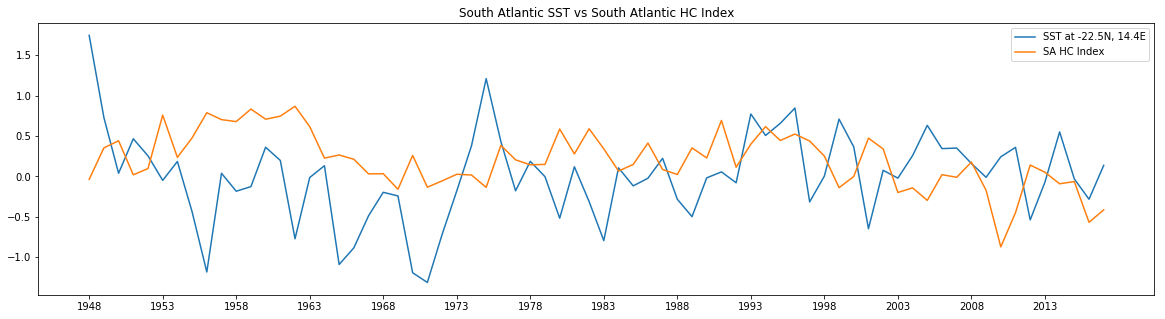

In [19]:
##################################################################################
#######  This cell will plot HC indices on top of the pointal time series   ######
##################################################################################

print(sst_sp.shape)
print(sp_indices.shape)

plot_timeseries(([center_zero(sst_sa), 'SST at -22.5N, 14.4E'],[sa_indices,'SA HC Index']),'South Atlantic SST vs South Atlantic HC Index',(np.arange(1948,2018,5)))

In [74]:
np.corrcoef(center_zero(sst_sp),np.squeeze(sp_indices))

array([[ 1.        , -0.35593532],
       [-0.35593532,  1.        ]])